In [11]:
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

In [16]:
SIFT_method = True
scaler = StandardScaler() 

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [5]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 30 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [6]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

In [7]:
import pandas as pd

def dataCreation(imgs,results,num_features):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()  
    else: 
        orb = cv2.ORB_create()  
    data = []
    keypoints = []
    descriptors = []
    dico = []
    for i in range(len(imgs)):
        if SIFT_method:
            kp, descriptors_temp = sift.detectAndCompute(img, None)
        else:
            kp, descriptors_temp = orb.detectAndCompute(img, None)
            keypoints.append(kp)
        descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            d = np.append(d,results[i])
            data.append(d)
           
    

    print(num_features)
    cols = []
    for i in range(num_features):
        cols.append('F'+str(i+1))
    
    cols.append('R')
        
    df = pd.DataFrame(data, columns = cols)
    
    return df,cols

In [8]:


import pandas as pd

def PCA_SIFT(df,cols,num_features,components):
    
    features = cols[:num_features]

    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    y = df.loc[:,['R']].values
    
    scaler.fit(x)    # Only the training data are used to fit the scaler transformation,
    x = scaler.transform(x)
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(x)

    cols2 = []
    for i in range(components):
        cols2.append('PC'+str(i+1))

    principalDf = pd.DataFrame(data = principalComponents, columns = cols2)
        
    #concateno valore vero
    finalDf = pd.concat([principalDf, df[['R']]], axis = 1)

    return finalDf, pca

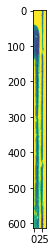

In [13]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pezziXimmagine = 1
border = 60

results = []
img_results = []
list_paths = []

list_paths = glob.glob(pathBuoni) 
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results +=  divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')

results += [0] * count * pezziXimmagine



list_paths = glob.glob(pathFS)
count = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results += [0] * count * pezziXimmagine

#list_paths += glob.glob(pathScarti)
#results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

#print(results)

#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_results[1])
plt.show()

In [17]:
if SIFT_method:
    num_features = 128
else:
    num_features = 32

In [18]:
df,cols = dataCreation(img_results,results,num_features)

128


In [19]:
file_name = 'dataframeSIFT.csv'
df.to_pickle(file_name) 

In [18]:
df = pd.read_pickle(file_name)


In [20]:
components = 64

In [21]:
cols = []
for i in range(num_features):
    cols.append('F'+str(i+1))

cols.append('R')

In [22]:

finalDf, pca = PCA_SIFT(df,cols,num_features,components)

In [23]:
finalDf

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,R
0,0.781970,1.206671,-4.082403,0.426020,-0.861652,-1.861127,1.937318,1.137878,3.353530,3.163323,...,-0.557366,0.502169,-0.691420,-0.363174,-0.677361,0.643658,0.132535,-0.437983,0.100207,0.0
1,0.936488,0.865020,-4.066900,1.277320,-1.073055,-0.643827,1.166947,1.175785,3.423019,1.503430,...,0.788799,0.292497,-0.749404,0.341909,-0.562644,1.018048,-0.134442,-0.597902,0.355085,0.0
2,0.446667,7.270054,-2.958326,-2.439406,-1.981062,-0.804749,-1.745057,-1.536443,1.404555,3.304074,...,1.069446,-0.028707,0.304404,-0.160804,-0.192847,0.216016,0.260508,0.255691,-0.948067,0.0
3,0.599694,5.584472,-1.797520,1.441623,0.149873,0.666173,-1.926815,-2.523307,-0.307480,0.650124,...,1.658888,0.336401,-0.323879,0.525112,-0.614525,0.436037,-0.136724,-0.389634,0.090923,0.0
4,-0.190661,3.545600,2.913984,-4.454043,0.188063,-1.111603,-4.676588,3.273051,0.781107,-0.214418,...,-0.391567,0.530209,0.073703,-0.088297,0.440581,0.883449,-0.394596,-0.273340,-0.612052,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388570,-2.535609,5.386867,0.518189,-0.425800,0.076532,0.891981,-3.566708,-1.900366,-0.477927,1.291758,...,-0.302125,1.032430,0.075890,0.465634,1.062902,0.301507,-0.013022,0.596055,0.596470,0.0
388571,-2.017200,3.915260,-0.288457,-3.116269,0.201891,0.520082,-3.648527,-1.866553,0.874692,1.315912,...,0.059667,0.438435,-0.381495,-0.745423,0.472108,0.408357,0.399529,1.547595,-0.503664,0.0
388572,-3.701708,2.626362,1.594260,-0.902171,-0.538611,0.152933,-3.087135,-3.617033,-0.450900,0.403231,...,-0.332033,0.373952,0.196525,0.006398,0.382362,-0.039081,-0.535277,-0.469230,0.035157,0.0
388573,-3.406036,3.874038,0.772986,-1.176070,0.563697,0.605415,-4.711614,0.607037,1.847291,0.475860,...,-0.188335,0.575811,-0.132119,-0.031381,0.156951,0.598595,-0.200923,-0.059364,-0.073025,0.0


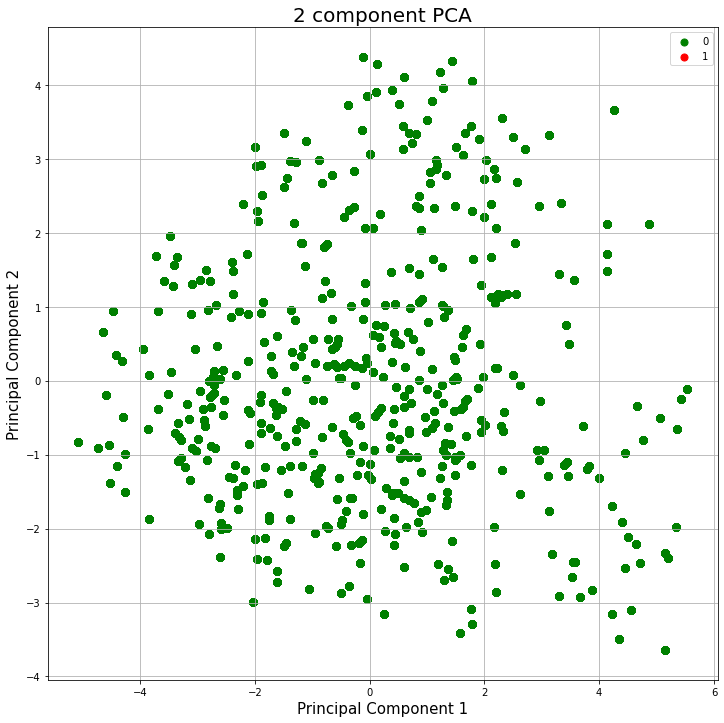

In [92]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['R'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
                #, finalDf.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [24]:
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/Cam3@00004 5.tif'


list_paths = glob.glob(pathScartiVal)
count = 0
img_results = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    try:
        img_results += divideImage(cutWorkSpace(img,border),pezziXimmagine)
        count += 1
    except:
        print('errore lettura')
        
results = [1] * count * pezziXimmagine

In [25]:
df2,cols = dataCreation(img_results,results,num_features)

128


In [26]:
features = cols[:num_features]
# Separating out the features
x = df2.loc[:, features].values
# Separating out the target
y = df2.loc[:,['R']].values
# Standardizing the features
x = scaler.fit_transform(x)

#pca = PCA(n_components=components)
principalComponents = pca.transform(x)

cols2 = []
for i in range(components):
    cols2.append('PC'+str(i+1))

principalDf = pd.DataFrame(data = principalComponents, columns = cols2)

#concateno valore vero
finalDf2 = pd.concat([principalDf, df2[['R']]], axis = 1)

In [27]:
frames = [finalDf, finalDf2]

finalDf3 = pd.concat(frames)

In [28]:
finalDf3

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,R
0,0.781970,1.206671,-4.082403,0.426020,-0.861652,-1.861127,1.937318,1.137878,3.353530,3.163323,...,-0.557366,0.502169,-0.691420,-0.363174,-0.677361,0.643658,0.132535,-0.437983,0.100207,0.0
1,0.936488,0.865020,-4.066900,1.277320,-1.073055,-0.643827,1.166947,1.175785,3.423019,1.503430,...,0.788799,0.292497,-0.749404,0.341909,-0.562644,1.018048,-0.134442,-0.597902,0.355085,0.0
2,0.446667,7.270054,-2.958326,-2.439406,-1.981062,-0.804749,-1.745057,-1.536443,1.404555,3.304074,...,1.069446,-0.028707,0.304404,-0.160804,-0.192847,0.216016,0.260508,0.255691,-0.948067,0.0
3,0.599694,5.584472,-1.797520,1.441623,0.149873,0.666173,-1.926815,-2.523307,-0.307480,0.650124,...,1.658888,0.336401,-0.323879,0.525112,-0.614525,0.436037,-0.136724,-0.389634,0.090923,0.0
4,-0.190661,3.545600,2.913984,-4.454043,0.188063,-1.111603,-4.676588,3.273051,0.781107,-0.214418,...,-0.391567,0.530209,0.073703,-0.088297,0.440581,0.883449,-0.394596,-0.273340,-0.612052,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,-0.565439,4.380789,-4.945388,-3.346601,1.494137,1.182934,2.543813,1.419593,1.036079,-1.495458,...,0.632049,-0.486442,0.727441,0.486914,0.176855,0.721585,-0.773599,0.098519,-0.247779,1.0
2718,-2.913582,5.670745,-0.383744,-0.076507,-0.394462,0.780914,-4.056169,0.471701,1.515605,1.444671,...,-0.251731,-0.057860,0.473888,-0.315229,-0.580041,-0.322667,0.140388,-0.430717,-0.044535,1.0
2719,-2.894595,4.671578,0.120520,-2.446332,0.197976,0.817713,-5.256274,-0.653777,1.683901,1.966698,...,0.985243,0.226475,-0.443803,0.614608,0.551490,0.124309,-0.439862,0.629657,-0.094252,1.0
2720,-2.645172,6.002235,-0.260421,-0.507079,-0.230639,1.274283,-2.777921,-2.241995,-0.995874,1.864187,...,0.258482,0.775536,0.151552,-0.138995,0.285810,0.703340,-1.048432,-0.244345,0.723076,1.0


Dato un DF restituisco la distanza media e massima dei punti che lo compongono

In [129]:
def maxAndMedian(df):
    df = df.sort_values(by=['PC1'],ascending=False)
    
    features = cols2[:components]
    # Separating out the features
    x = df.loc[:, features].values
    
    maxT = 0
    totale = 0
    if SIFT_method:
        tot_element = [0]*components
    else:
        tot_element = [0]*components
    for element in x:
        temp = np.linalg.norm(element)
        totale += temp
        tot_element += element
        if temp > maxT:
            maxT = temp
            
    media = totale / len(x)
    
    media_list = np.mean(x, axis=0)

    centerDist = np.linalg.norm(tot_element/len(x))
        
    return maxT, media,centerDist

In [130]:
maxT, media,centerDist = maxAndMedian(finalDf2)
print(maxT)
print(media)
print(centerDist)

6.324741487045763
4.064446028170509
8.612538708832856e-16


In [123]:
maxT, media,centerDist = maxAndMedian(finalDf)
print(maxT)
print(media)
print(centerDist)

6.7896790071649775
4.261841899903259
1.8835660000209042e-13


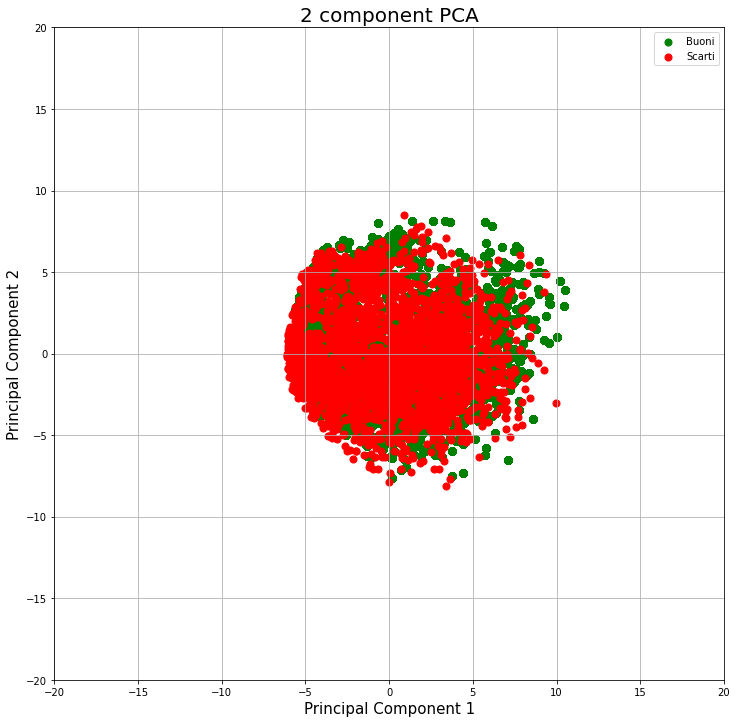

In [29]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['g', 'r']
#circle = plt.Circle((0, 0), 5.95, color='b')
#ax.add_artist(circle)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf3['R'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
                #, finalDf3.loc[indicesToKeep, 'R']
               , c = color
               , s = 50)
targets = ['Buoni', 'Scarti']
ax.legend(targets)
ax.grid()

In [38]:
def test_pca_score(df,cols,pca):
    features = cols

    # Separating out the features
    x = df.loc[:, features[0:len(features)-1]].values
    # Separating out the target
    y = df.loc[:,['R']].values
    x = scaler.transform(x)

    
    return (pca.score(x))

In [43]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = st

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [1] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
scoreST = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    #train_images = np.array(img_results)
    #train_images = train_images/255.
    #imgsWithClass = [train_images,results]
    df4,feature_cols = dataCreation(img_results,results,num_features)
    #df4,feature_cols = createDF(imgsWithClass)
    scoreST.append(test_pca_score(df4,feature_cols,pca))



9
128
128
128
128
128
128
128
128
128


In [44]:
pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'
st = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'
tot = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


results = []
list_paths = []

pathToTest = pathBuoni

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [1] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
scoreB = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    #train_images = np.array(img_results)
    #train_images = train_images/255.
    #imgsWithClass = [train_images,results]
    df4,feature_cols = dataCreation(img_results,results,num_features)
    #df4,feature_cols = createDF(imgsWithClass)
    scoreB.append(test_pca_score(df4,feature_cols,pca))




119
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [50]:
pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'



results = []
list_paths = []

pathToTest = pathBuoniVal

list_paths = glob.glob(pathToTest) 
print(len(list_paths))
results = [1] * len(glob.glob(pathToTest)) * pezziXimmagine
img_results = []
scoreBV = []
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    #train_images = np.array(img_results)
    #train_images = train_images/255.
    #imgsWithClass = [train_images,results]
    df4,feature_cols = dataCreation(img_results,results,num_features)
    #df4,feature_cols = createDF(imgsWithClass)
    scoreBV.append(test_pca_score(df4,feature_cols,pca))





79
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


In [53]:
min(scoreST)

-132.4129569615586

In [49]:
min(scoreB)

-144.25843440688973

In [52]:
min(scoreBV)

-138.54341267894668